# Text Classification_LSTM
<br>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [3]:
# train 데이터 로드
train_data_aug = pd.read_csv('./data/train_aug.csv')
print('훈련용 텍스트 개수 :',len(train_data_aug))

훈련용 텍스트 개수 : 15800


In [4]:
train_data_aug.drop_duplicates(subset=['conversation'], inplace=True)
train_data_aug = train_data_aug.dropna(how='any')

print('훈련 데이터의 대화문 수:',len(train_data_aug))

훈련 데이터의 대화문 수: 15624


In [5]:
train_data_aug = train_data_aug.dropna(subset=['class'])
print(train_data_aug['class'].unique())

['직장 내 괴롭힘 대화' '기타 괴롭힘 대화' '갈취 대화' '협박 대화']


In [6]:
# 레이블 값을 숫자로 매핑
label_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3
}

In [7]:
# 훈련용 데이터(train_data_aug)의 레이블 값을 숫자로 변환
train_data_aug['class'] = train_data_aug['class'].map(label_mapping)

In [8]:
# 훈련용 데이터 tokenization

In [9]:
tokenizer = Tokenizer(num_words=20000)

In [10]:
tokenizer.fit_on_texts(train_data_aug['conversation'])

train_X = tokenizer.texts_to_sequences(train_data_aug['conversation'])
train_X = pad_sequences(train_X, maxlen=200)
train_y = train_data_aug['class'].values

In [11]:
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

In [12]:
print(f"Training data size: {len(train_X)}")
print(f"Validation data size: {len(val_X)}")

Training data size: 12499
Validation data size: 3125


In [13]:
# LSTM 모델 구성

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [17]:
vocab_size = 20000
embedding_dim = 32
max_len = 200

In [18]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(4, activation="softmax"))

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [21]:
history = model.fit(
    train_X, train_y,
    batch_size=32,
    epochs=5,
    validation_data=(val_X, val_y),
    callbacks=[early_stopping]
)

Epoch 1/5
391/391 [==============================] - 17s 18ms/step - loss: 1.3954 - accuracy: 0.2952 - val_loss: 1.3859 - val_accuracy: 0.2618
Epoch 2/5
391/391 [==============================] - 6s 16ms/step - loss: 1.3845 - accuracy: 0.2743 - val_loss: 1.3853 - val_accuracy: 0.2672
Epoch 3/5
391/391 [==============================] - 7s 17ms/step - loss: 1.3836 - accuracy: 0.2766 - val_loss: 1.3802 - val_accuracy: 0.2672
Epoch 4/5
391/391 [==============================] - 6s 16ms/step - loss: 0.7978 - accuracy: 0.6525 - val_loss: 0.3478 - val_accuracy: 0.8736
Epoch 5/5
391/391 [==============================] - 7s 17ms/step - loss: 0.1891 - accuracy: 0.9411 - val_loss: 0.1432 - val_accuracy: 0.9584


In [22]:
print("훈련 정확도: %.4f" % (model.evaluate(train_X, train_y)[1]))

391/391 [==============================] - 3s 7ms/step - loss: 0.0637 - accuracy: 0.9809
훈련 정확도: 0.9809


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

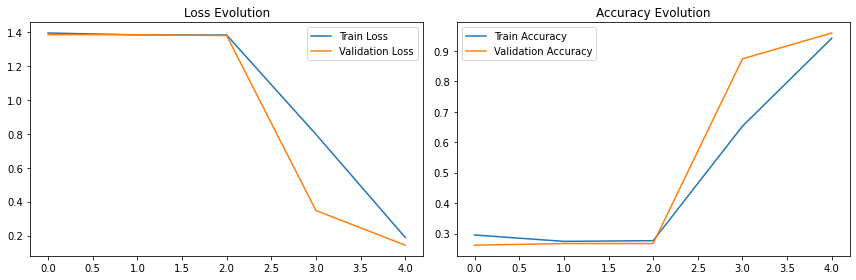

In [24]:
# 훈련과정 그래프
def plot_training_history(history):
    # Loss plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Evolution')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [25]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns

In [26]:
# 모델을 사용하여 예측 수행
val_predictions = np.argmax(model.predict(val_X), axis=-1)

In [27]:
# f1 score 출력
f1 = f1_score(val_y, val_predictions, average='macro')
print(f"F1 Score: {f1}\n")

F1 Score: 0.958428588196951



In [28]:
# classification report 출력
report = classification_report(val_y, val_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       716
           1       0.99      0.95      0.97       756
           2       1.00      0.98      0.99       818
           3       0.93      0.93      0.93       835

    accuracy                           0.96      3125
   macro avg       0.96      0.96      0.96      3125
weighted avg       0.96      0.96      0.96      3125



In [29]:
# confusion matrix 시각화
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm_norm, annot=cm, fmt='g', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

In [30]:
# 클래스 라벨 
classes = ["class_0", "class_1", "class_2", "class_3"]

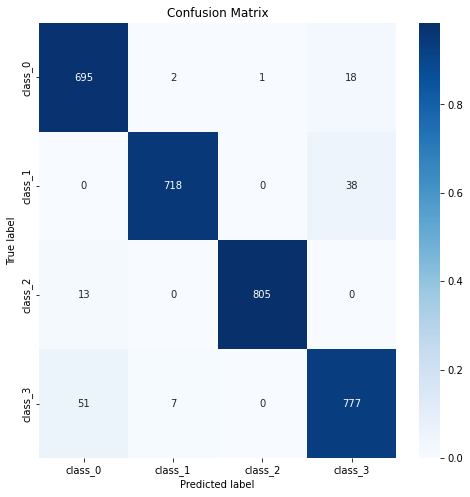

In [31]:
plot_confusion_matrix(val_y, val_predictions, classes)

In [32]:
# prediction

In [33]:
def multi_class_predict(new_sentence):
    new_sentence = tokenizer.texts_to_sequences([new_sentence])
    new_sentence = pad_sequences(new_sentence, maxlen=max_len)

    score = model.predict(new_sentence)[0]

    class_names = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']
    max_score_index = np.argmax(score)
    predicted_class = class_names[max_score_index]
    probability = score[max_score_index] * 100  # 확률을 %로 변환

    print("해당 문장은 {:.2f}%의 확률로 '{}'로 분류됩니다.".format(probability, predicted_class))

In [34]:
multi_class_predict("참 애매하시네요.")

해당 문장은 99.25%의 확률로 '협박 대화'로 분류됩니다.


In [35]:
multi_class_predict("돈 내놔")

해당 문장은 86.44%의 확률로 '협박 대화'로 분류됩니다.


In [36]:
import pandas as pd

# JSON 파일을 dataframe으로 로드
df = pd.read_json('./data/test.json')
df_flipped = df.transpose()

# 처음 5행 출력
df_flipped.head()

pd.set_option('display.max_rows', 500)
df_flipped

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
t_005,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...
t_006,그 사람 누구냐? 누구말하는거야? 다 알면서 모른척 하지마. 둘다 쏴버리기 전에...
t_007,야 저기야 닭꼬치 트럭왔다 응 그러네 그치? 너도 먹고 싶지? 어?나도? 그래 너 ...
t_009,야 너 2학년 김민석 맞지? 네 맞는데요. 혹시 누구신가요? 내가 누군지 궁금하면 ...
t_010,예전에 네가 나한테 했던 일 기억하지? 너도 당해봐 예전 일이라면 내가 사과할게. ...
t_012,김비서 지금 우리애 학교가서 집에다가 좀 데려다 주세요 사장님 그런 개인적인 일은 ...


In [37]:
def get_predicted_class(new_sentence):
    new_sentence = tokenizer.texts_to_sequences([new_sentence])
    new_sentence = pad_sequences(new_sentence, maxlen=max_len)

    score = model.predict(new_sentence)[0]

    class_names = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']
    predicted_class = class_names[np.argmax(score)]

    return predicted_class

In [38]:
# 예측된 클래스 값에 따른 매핑 생성
class_mapping = {
    '협박 대화': '00',
    '갈취 대화': '01',
    '직장 내 괴롭힘 대화': '02',
    '기타 괴롭힘 대화': '03'
}

In [39]:
# df_flipped의 각 문장에 대해 예측 클래스를 얻습니다.
df_flipped['predicted_class'] = df_flipped['text'].apply(get_predicted_class)

In [40]:
# 예측된 클래스를 코드로 매핑
df_flipped['class'] = df_flipped['predicted_class'].map(class_mapping)

In [41]:
df_flipped.drop(columns=['text'], inplace=True)
df_flipped.drop(columns=['predicted_class'], inplace=True)

In [43]:
# 변환된 dataframe의 처음 5행 출력(확인용)
df_flipped.head()

,class
t_000,01
t_001,02
t_002,00
t_004,00
t_005,00


In [44]:
# 'class' 열의 값을 두 자리 숫자로 변환
df_flipped['class'] = df_flipped['class'].astype(int).apply(lambda x: f"{x:02}")

# 변환된 dataframe의 처음 5행 출력(확인용)
df_flipped.head()

,class
t_000,01
t_001,02
t_002,00
t_004,00
t_005,00


In [45]:
import datetime

# 현재 날짜와 시간 가져오기
now = datetime.datetime.now()

# 날짜와 시간을 원하는 형식으로 포맷팅
date_time_str = now.strftime("%Y%m%dT%H%M")

# 파일명 생성
file_name = f"submission{date_time_str}.csv"

# submission.csv 파일을 날짜패턴 합쳐 만들기
df_flipped.to_csv(file_name)